# ST4 MDS : TP 4 Model Based Agent : Franke & Westerhoff model

![CentraleSupelec Logo](https://www.centralesupelec.fr/sites/all/themes/cs_theme/medias/common/images/intro/logo_nouveau.jpg)

## AIMS of the TP : 

* 1. To implement Franke & Westerhoff’s model.
* 2. To explore the behaviour of this model.
* 3. To calibrate this model.

In [1]:
import numpy as np 
import random as rd 
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd 
import powerlaw as pw
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")

In [2]:
__author__ = "Colleville Tanguy, Matthieu Briet"
__copyright__ = "None"
__credits__ = ["None"]
__license__ = "None"
__version__ = "1.0.0"
__maintainer__ = "Colleville Tanguy, Matthieu Briet"
__email__ = "tanguy.colleville@student-cs.fr, matthieu.briet@student-cs.fr"
__status__ = "Dev"

In [3]:
plt.rcParams["figure.figsize"] = (12,6)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
prix_fondamental=1
np.random.seed(0)

In [4]:
def plot_PL(xmin,xmax,ymax,alpha):
    ## plot une power law distribution
    ## y max est le facteur d'ajustement
    dx = np.linspace(xmin,xmax,5)
    
    y = dx**(-alpha)
    
    return dx,ymax*y/y[0]

Rationale Prediction
* A good ABM captures fundamental elements of market
dynamics.
* Its internal state at time t contains some information
about the future

#### Model in a noteshell :

 Asset price changes are determined by excess demand on a market populated by two types of speculative traders—fundamentalists and chartists. Fundamentalists have long time horizons and base their demand on the differences between the current price and the fundamental valueChartists, on the other hand, have a short-term perspective and bet on the most recent price movements, buying (selling) if prices have been rising (falling).

 By construction, $x_t$ is contained between −1 (all traders are chartists) and +1 (all traders are fundamentalists).

 the coefficient $\alpha_0$ can be interpreted as a predisposition parameter, since in a balanced state xt = 0 where also the other effects cancel out, a positive (negative) $\alpha_0$ would give rise to an aggregate motion in the direction of fundamentalism (chartism). The more traders are already fundamentalists (i.e. the higher xt)

 $\phi$ represents the speed with fundamentalists believe the market will converge to fundamental value.  Apparently ( $0<\phi \leq1$ )   
 $\chi$ denotes the strength of speculators’ extrapolation behavior.  
 
 $p∗$ represents the fundamental value which is fixed and known.  

## 1. To implement Franke & Westerhoff’s model.

$$r_{t+1}=\frac{\mu}{2}[(1+x_t)\phi(p^*-p_t)+(1-x_t)\chi(p_t-p_{t-1})+\epsilon_t]$$
$$\epsilon \sim \mathcal{N}(0,\,\sigma_t^{2})$$
$$\sigma_t^{2}=\frac{1}{2}*[(1+x_t)^2\sigma_f^2+(1-x_t)^2\sigma_c^2]$$
$$x_{t+1}=x_t+\nu[(1-x_t)exp(s_t)-(1+x_t)exp(-s_t)]$$
$$s_t=\alpha_0+\alpha_x x_t+\alpha_d(p^*-p_t)^2$$

In [5]:
def Franke_Westerhoff(phi,khi,mu,nu,alpha_0,alpha_x,alpha_d,sigma_f,sigma_c,NIT=10000,fp=0):
    x_t=np.zeros(NIT)
    p_t=np.zeros(NIT)
    r_t=np.zeros(NIT)
    s_t=np.zeros(NIT)
    sigma=np.zeros(NIT)
    epsilon=np.zeros(NIT)
    for i in range(2,NIT):
        sigma[i]=0.5*(((1+x_t[i-1])**2)*sigma_f**2+((1-x_t[i-1])**2)*sigma_c**2)
        epsilon[i]=np.random.normal(0,np.sqrt(sigma[i]))
        r_t[i]=(mu/2)*((1+x_t[i-1])*phi*(fp-p_t[i-1])+(1-x_t[i-1])*(khi*(p_t[i-1]-p_t[i-2]))+epsilon[i-1])
        p_t[i]=p_t[i-1]+r_t[i]
        x=x_t[i-1]+nu*((1-x_t[i-1])*np.exp(s_t[i-1])-(1+x_t[i-1])*np.exp(-s_t[i-1]))
        if x>=0:
            x_t[i]=min(1,x)
        elif x<0:
            x_t[i]=max(-1,x)
        s_t[i]=alpha_0+alpha_x*x_t[i]+alpha_d*(fp-p_t[i])**2
    return r_t,x_t


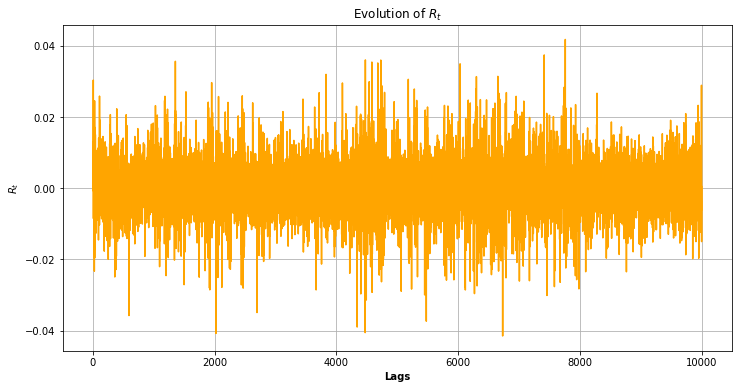

In [6]:
T=10000
R_t,X_t=Franke_Westerhoff(0.18,2.35,0.01,2.57,-0.15,1.35,11.4,0.79,1.91,NIT=10000)

plt.figure()
plt.plot(np.linspace(0,10000-1,10000),R_t,label=r"$R_t$",color="orange")
plt.title(r"Evolution of $R_t$")
plt.xlabel(r"Lags")
plt.ylabel(r"$R_t$")
# plt.xscale("log")
# plt.yscale("log")
plt.grid()
plt.show()

$R_t$ seems to be stationnary. We can be convinced by this hypothesis with the Dickey Fuller Test.
### Dickey-Fuller Test is testing if the time series is stationnary : 
We know that Dickey-Fuller test is a generalisation of testing the square root of characteristic polynomial. 
In fact, the hypothesis $$H_0 : | \rho | = 1 $$, meaning Non stationnarity I.E TCL falling.  
Against $$H_1 : | \rho | < 1 $$  meaning stationnarity
Therefore if the p-value is big we have to accept the $H_0$ hypothesis. On the contrary if the p-value is low we can reject $H_0$ and accept $H_1$. The threshold could be set at 0.1. 

In [7]:
print("P-value of Dickey-Fuller Test : ", adfuller(R_t)[1]) 

P-value of Dickey-Fuller Test :  0.0


p-value is very low therefore $R_t$ is stationnary

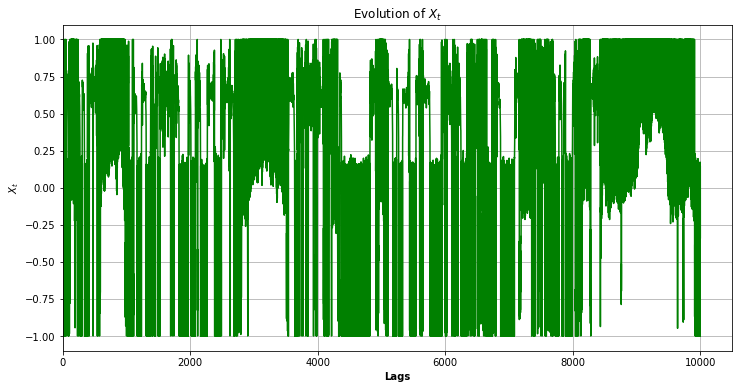

In [8]:
plt.figure()
plt.plot(np.linspace(0,10000-1,10000),X_t,label=r"$X_t$",color="green")
plt.title(r"Evolution of $X_t$")
plt.xlabel(r"Lags")
plt.ylabel(r"$X_t$")
# plt.xscale("log")
# plt.yscale("log")
plt.xlim(left=0)
plt.grid()
plt.show()

## 2. To explore the behaviour of this model.

In [9]:
ft=pw.Fit(np.abs(R_t))
alpha=ft.alpha
X_min=ft.xmin
X_max=np.max(R_t)

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


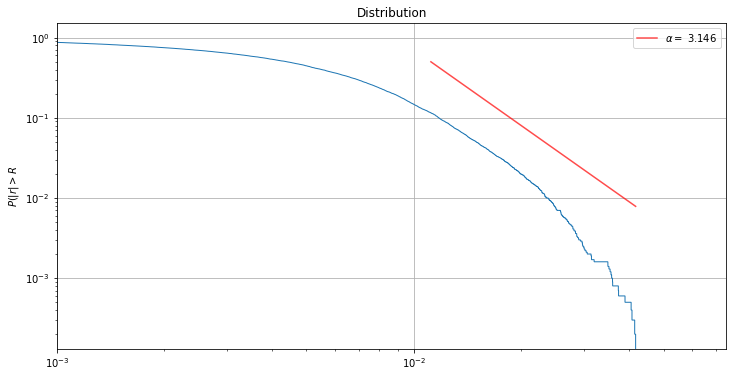

In [10]:
dx,dy=plot_PL(X_min,X_max,5e-1,alpha-1)
plt.plot(dx,dy,c="red",alpha=0.7,label=r"$\alpha=$ {}".format(round(alpha-1,3)))

bn = sorted(set(np.abs(R_t))) 

plt.hist(np.abs(R_t),bins=bn,density=True,cumulative=-1,histtype='step')


plt.title("Distribution")
plt.xlabel("")
plt.ylabel(r"$P(|r|>R$")
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.xlim(xmin=1e-3)
plt.grid()
plt.show()

### Fat tails : GCLT 
Gnedenko and Kolmogorov generalized the central limit theorem and proved that the sum of variable
coming any symmetric distribution with power-law tails $ |x|^{-\alpha - 1}$ with 0<$\alpha$<=2,will converge to a stable distribution with infinite variance. If the exponent $\alpha$>2 it will converge to a a stable with stability parameter equal to 2, which is a normal. Therefore, here we can say that the CLT still apply. 

Even if $\phi$ and $\chi$ must be positives we just wanted to see the impact of negatives values. Moreover, as we can see in the lecture (slide 33) and in the original publication, we already have an idea of the values taken by $\phi$, $\chi$ and $\alpha_0$

In [11]:
nb_test=50

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than

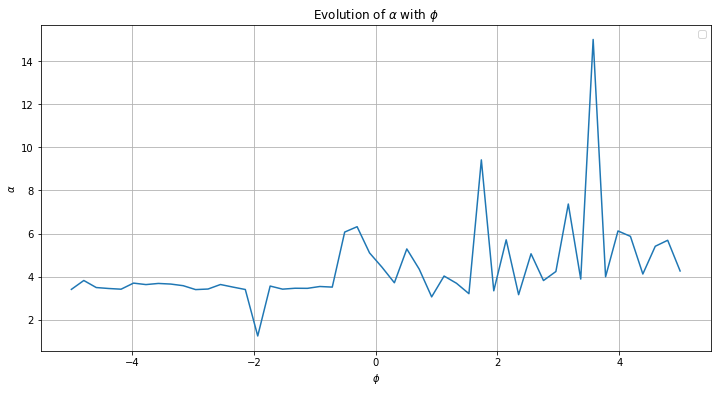

In [12]:
list_phi=np.linspace(-5,5,nb_test)
alpha_phi=[]
for index,phi in enumerate(list_phi):
    R_t,X_t=Franke_Westerhoff(phi,2.35,0.01,2.57,-0.15,1.35,11.4,0.79,1.91,NIT=1000)
    ft=pw.Fit(np.abs(R_t))
    alpha_phi.append(ft.alpha)

plt.title(r"Evolution of $\alpha$ with $\phi$")
plt.xlabel(r"$\phi$")
plt.ylabel(r"$\alpha$")
plt.plot(list_phi,alpha_phi)
plt.legend()
plt.grid()
plt.show()

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
5.622324742036228
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
4.711136177686166
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
4.939533593005217
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
4.587239482384584
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
6.24931655648868
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
2.7319065939787075
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
4.421106202761869
Values less t

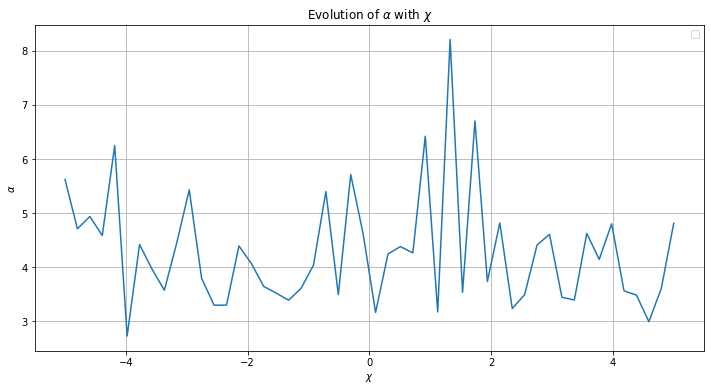

In [13]:
list_khi=np.linspace(-5,5,nb_test)
alpha_khi=[]
for index,khi in enumerate(list_khi):
    R_t,X_t=Franke_Westerhoff(0.18,khi,0.01,2.57,-0.15,1.35,11.4,0.79,1.91,NIT=1000)
    ft=pw.Fit(np.abs(R_t))
    print(ft.alpha)
    alpha_khi.append(ft.alpha)

plt.title(r"Evolution of $\alpha$ with $\chi$")
plt.xlabel(r"$\chi$")
plt.ylabel(r"$\alpha$")
plt.plot(list_khi,alpha_khi)
plt.legend()
plt.grid()
plt.show()

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than

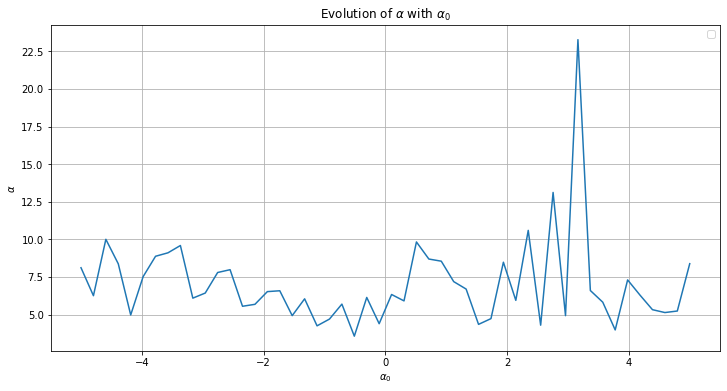

In [14]:
list_alpha0=np.linspace(-5,5,nb_test)
alpha_0=[]
for index,alpha0 in enumerate(list_alpha0):
    R_t,X_t=Franke_Westerhoff(0.18,2.35,0.01,2.57,alpha0,1.35,11.4,0.79,1.91,NIT=1000)
    ft=pw.Fit(np.abs(R_t))
    alpha_0.append(ft.alpha)

plt.title(r"Evolution of $\alpha$ with $\alpha_0$")
plt.xlabel(r"$\alpha_0$")
plt.ylabel(r"$\alpha$")
plt.plot(list_alpha0,alpha_0)
plt.legend()
plt.grid()
plt.show()

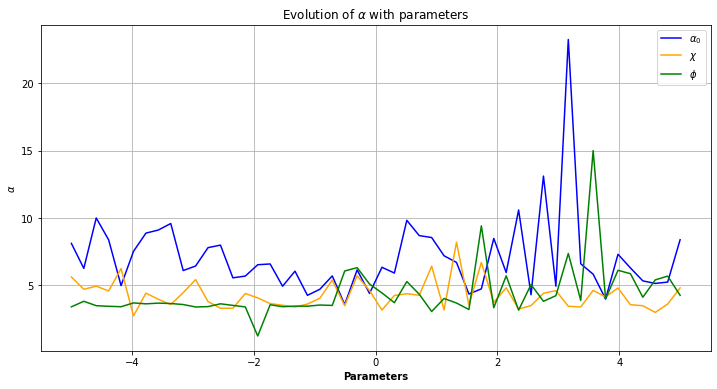

In [15]:
plt.title(r"Evolution of $\alpha$ with parameters")
plt.plot(list_alpha0,alpha_0,label=r"$\alpha_0$",color="blue")
plt.plot(list_khi,alpha_khi,label=r"$\chi$",color="orange")
plt.plot(list_phi,alpha_phi,label=r"$\phi$",color="green")
plt.xlabel(r"Parameters")
plt.ylabel(r"$\alpha$")
plt.legend()
plt.grid()
plt.show()

We can see that the results are not constant while running the calculus. 
* for $\phi$ near the border of (0;1) the C value is high and on the contrary the C value is lower in the middle of the intervalle.  
* for $\chi$, C is high when $\chi$ is about 1.6 even though it is almost constant 
* for $\alpha_0$ it seems that there is a spike for $\alpha_0$ = 3.2 but for negative values, as $\alpha_0$ should be negative, this is almost constant

## 3. To calibrate this model.

In [16]:
df=pd.read_csv(r"rt.csv",index_col=0)
print(df.shape)
print(df.describe())

(10000, 1)
                  0
count  10000.000000
mean      -0.000030
std        0.026213
min       -0.109828
25%       -0.017405
50%        0.000031
75%        0.017638
max        0.120424


In [17]:
df.isna().sum() #No NaN 

0    0
dtype: int64

In [18]:
assets=df.columns ## only one asset

In [19]:
FW_calib=df[assets[0]].values
FW_calib

array([ 0.        ,  0.        , -0.00575433, ...,  0.00966614,
        0.02619904,  0.03402465])

### 3.1 Exploration : tail 

In [21]:
ft=pw.Fit(np.abs(FW_calib))
c_file=ft.alpha-1
X_min=ft.xmin
X_max=np.max(FW_calib)

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


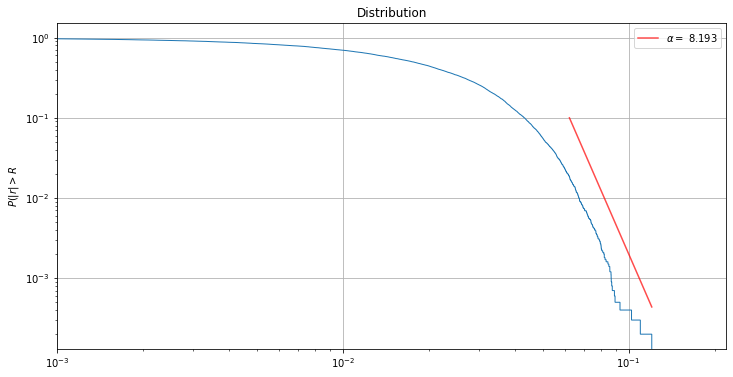

In [22]:
dx,dy=plot_PL(X_min,X_max,1e-1,c_file)
plt.plot(dx,dy,c="red",alpha=0.7,label=r"$\alpha=$ {}".format(round(c_file,3)))

bn = sorted(set(np.abs(FW_calib))) 

plt.hist(np.abs(FW_calib),bins=bn,density=True,cumulative=-1,histtype='step')


plt.title("Distribution")
plt.xlabel("")
plt.ylabel(r"$P(|r|>R$")
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.xlim(xmin=1e-3)
plt.grid()
plt.show()

### Fat tails : GCLT 
Gnedenko and Kolmogorov generalized the central limit theorem and proved that the sum of variable
coming any symmetric distribution with power-law tails $ |x|^{-\alpha - 1}$ with 0<$\alpha$<=2,will converge to a stable distribution with infinite variance. If the exponent $\alpha$>2 it will converge to a a stable with stability parameter equal to 2, which is a normal. Therefore, here we can say that the CLT still apply. We can notice that the exponent is much bigger than the previous one in part 2. 

### 3.2 Optimization 

In [43]:
def Loss_function(params):
    phi,khi,alpha_0=params
    if phi<0 : 
        phi=0.0000001
    if khi<0 : 
        khi=0.0000001
    if alpha_0>0 : 
        alpha_0=-0.0000001
    R_t,X_t=Franke_Westerhoff(phi,khi,0.01,2.57,alpha_0,1.35,11.4,0.79,1.91,NIT=1000)
    ft=pw.Fit(np.abs(R_t))
    c_model=ft.alpha-1
    return (c_file-c_model)**2

In [54]:
from skopt import gp_minimize
intervalle_phi=(0,1)
intervalle_chi=(0,3)
intervalle_alpha_0=(-3,0)

res = gp_minimize(Loss_function, [intervalle_phi,intervalle_chi,intervalle_alpha_0], n_calls=100,n_jobs=-1,verbose=True)

or power law fit
Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 2.7250
Function value obtained: 5.1275
Current minimum: 1.3410
Iteration No: 41 started. Searching for the next optimal point.
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 2.4243
Function value obtained: 14.8746
Current minimum: 1.3410
Iteration No: 42 started. Searching for the next optimal point.
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 2.2841
Function value obtained: 22.1296
Current minimum: 1.3410
Iteration No: 43 started. Searching for the next optimal point.
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power

In [55]:
print("phi*=%.2f,chi*=%.2f, alpha_0*=%.2f f(x*)=%.2f" % (res.x[0],res.x[1],res.x[2], res.fun))

phi*=1.00,chi*=0.00, alpha_0*=-3.00 f(x*)=0.01


Why does a straightforward optimization fail to be of much help ? Sloppy models are called 'poorly constrained' and 'ill-conditioned' because it is difficult to use experimental data to figure out what their parameters are. This is exactly the case here. To show that a model is sloppy we have to show that some eigenvectors have small eigenvalues. To do this we have to compute the Hessian matrix and then computing the eigenvalues.  
Moreover, we can say that the optimization is very depend on the domain for each variable. 

#### Tâtonnement 
from our understanding of how c depends on the parameters, we have test manually to fit the model. It is definetly not an efficient way to fit a model. 

In [34]:
parametres=[(0,0,0),(0.4,1,-0.5),(0.4,1.3,-0.38),(0.4,1.2,-0.36)]

In [35]:
for param in parametres:
    print("parameters=",param,"Loss_function", Loss_function(param))

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
parameters= (0, 0, 0) Loss_function 5.610715841416536
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
parameters= (0.4, 1, -0.5) Loss_function 17.780249228395157
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
parameters= (0.4, 1.3, -0.38) Loss_function 13.978910301526085
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
parameters= (0.4, 1.2, -0.36) Loss_function 22.76584336531285


### 3.3 Calibrate II 

In [28]:
epochs=200
param_set=[0.195,2.35,0.57,-0.15]
phi,chi,nu,alpha0=param_set
C,moy,var=[],[],[]
for epoch in range(epochs):
    X,R=Franke_Westerhoff(phi,chi,0.01,nu,alpha0,1.35,11.4,0.79,1.91,NIT=1000)
    ft=pw.Fit(np.abs(X))
    C.append(ft.alpha-1)
    moy.append(np.mean(C))
    var.append(np.var(C))

out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negativ

In [29]:
mean_1=np.mean(C)
var_1=np.var(C)
print("\u03BC = ", mean_1)
print("\u03C3 ² = ",var_1)

μ =  3.5403235352245064
σ ² =  2.7308938723208223


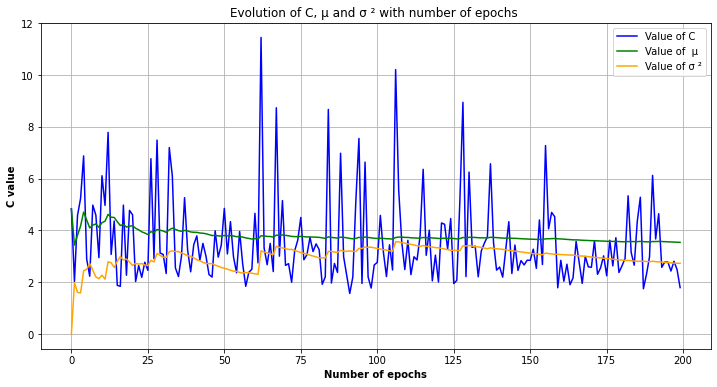

In [30]:
plt.figure()
plt.title("Evolution of C, \u03BC and \u03C3 ² with number of epochs ")
plt.plot(C,label="Value of C", color ="blue")
plt.plot(moy,label="Value of  \u03BC", color ="green")
plt.plot(var,label="Value of \u03C3 ²", color ="orange")
plt.xlabel("Number of epochs")
plt.ylabel("C value")
plt.legend()
plt.grid()
plt.show()

We can see that the uncertainty over the runs is very large but seems to slightly decrease over epochs. By the way the mean also seems to decay over epochs. 

## Conclusion 

In this practical work we have implemented Franke et Westerhoff' model. We have computed the best parameters for a certain configuration of this model. As long as this model is sloppy, parameters optimization is a very complicated task to achive. We tried to do an optimization by hand which is not a very efficient way to get optimality. Finally we can see that the variance of the exponent along epochs is very high which is not a very good thing. 

# Sources 
* Données et Statistiques en Finance: modeles d’agents IV
* [Franke Westerhoff](https://www.uni-bamberg.de/fileadmin/uni/fakultaeten/sowi_lehrstuehle/vwl_finanzwissenschaft/Forschung/BERG/Nr.61_F.Westerhoff.pdf)
* [Franke Westerhoff cours](https://www.uni-bamberg.de/fileadmin/uni/fakultaeten/sowi_lehrstuehle/vwl_wirtschaftspolitik/Team/Westerhoff/Publications/2010/2010_Pbl_Franke_Westerhoff.pdf)
* [GP Minimize] (https://scikit-optimize.github.io/stable/modules/generated/skopt.gp_minimize.html)
* [Bayesian optimization](https://scikit-optimize.github.io/stable/auto_examples/bayesian-optimization.html)
* [Sethna et al](https://arxiv.org/pdf/0704.3049.pdf)